<div>
<font size=4> Description </font> <br>
    a code to give value to null data, based on multiple imputation. 
</div>

In [134]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fancyimpute import KNN
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [111]:
df = pd.read_csv('prepared_for_rsf_with_null.csv')
df['BC'] *= 10 # Categorical
df.head(10)

,Y,AF,AQ,AY,BC,BE,BG,BH,BI,BL,...,DE,DT,DW,DX,DY,EZ,Age,metastasis,dead,secondprim
0,1.0,1.0,4.0,NaN,NaN,NaN,2.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,103,44.0,NaN,1,2.0
1,1.0,2.0,4.0,2.0,NaN,NaN,2.0,1.0,1.0,NaN,...,1.0,1.0,2.0,1.0,1.0,153,51.0,2.0,1,2.0
2,2.0,2.0,4.0,NaN,45.0,NaN,2.0,1.0,1.0,NaN,...,1.0,2.0,2.0,2.0,2.0,160,53.0,2.0,1,2.0
3,2.0,2.0,2.0,3.0,NaN,NaN,2.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,115,59.0,NaN,1,2.0
4,1.0,2.0,4.0,NaN,NaN,NaN,2.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,52,40.0,2.0,1,2.0
5,2.0,2.0,6.0,NaN,NaN,NaN,2.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,298,33.0,NaN,1,2.0
6,2.0,2.0,2.0,2.0,NaN,NaN,1.0,1.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,168,83.0,NaN,1,2.0
7,2.0,2.0,2.0,2.0,50.0,5.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,162,80.0,NaN,1,2.0
8,2.0,2.0,2.0,3.0,30.0,NaN,1.0,1.0,2.0,1.0,...,1.0,1.0,1.0,1.0,2.0,76,71.0,2.0,1,2.0
9,1.0,2.0,NaN,NaN,NaN,NaN,2.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,225,57.0,NaN,1,2.0


Text(0.5, 1.0, 'dead patients')

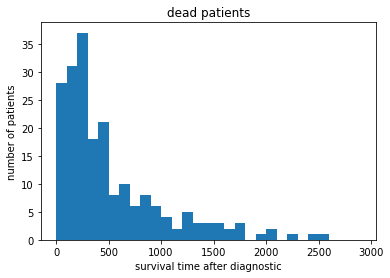

In [112]:
plt.hist(df[df['dead'] == 1]['EZ'], bins = range(0, 3000, 100))
plt.xlabel('survival time after diagnostic')
plt.ylabel('number of patients')
plt.title('dead patients')

Text(0.5, 1.0, 'alive patients')

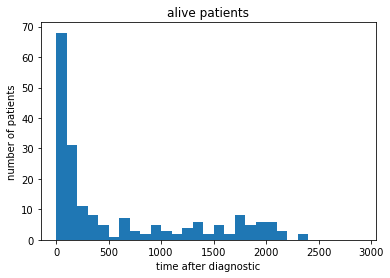

In [113]:
plt.hist(df[df['dead'] == 2]['EZ'], bins = range(0, 3000, 100))
plt.xlabel('time after diagnostic')
plt.ylabel('number of patients')
plt.title('alive patients')

In [128]:
# get insight about number of null values
pd.DataFrame(df.shape[0] - df.count())

,0
Y,41
AF,36
AQ,28
AY,111
BC,141
BE,414
BG,5
BH,51
BI,65
BL,88


In [127]:
# get insight about different values that our features can acquire

cols = list(df.columns)
cols.remove('Age')
cols.remove('EZ')

for col in cols:
    print(df[col].value_counts())

# All categorical ...

<font size=4>Fancy Imputer based on KNN </font><br>
$k = 5$ is set.

In [130]:
imputer = KNN(k=5, orientation='rows', print_interval=100, verbose=True)
encode_data = pd.DataFrame(np.round(imputer.fit_transform(df)), columns = df.columns)
encode_data['BC'] /= 10
imp = encode_data

Imputing row 1/526 with 12 missing, elapsed time: 0.082
Imputing row 101/526 with 12 missing, elapsed time: 0.090
Imputing row 201/526 with 5 missing, elapsed time: 0.095
Imputing row 301/526 with 3 missing, elapsed time: 0.104
Imputing row 401/526 with 1 missing, elapsed time: 0.113
Imputing row 501/526 with 9 missing, elapsed time: 0.123


In [131]:
imp.head(10)

,Y,AF,AQ,AY,BC,BE,BG,BH,BI,BL,...,DE,DT,DW,DX,DY,EZ,Age,metastasis,dead,secondprim
0,1.0,1.0,4.0,4.0,7.3,3.0,2.0,1.0,1.0,1.0,...,1.0,2.0,2.0,2.0,2.0,103.0,44.0,2.0,1.0,2.0
1,1.0,2.0,4.0,2.0,4.2,8.0,2.0,1.0,1.0,1.0,...,1.0,1.0,2.0,1.0,1.0,153.0,51.0,2.0,1.0,2.0
2,2.0,2.0,4.0,2.0,4.5,6.0,2.0,1.0,1.0,1.0,...,1.0,2.0,2.0,2.0,2.0,160.0,53.0,2.0,1.0,2.0
3,2.0,2.0,2.0,3.0,5.6,3.0,2.0,1.0,1.0,1.0,...,1.0,1.0,2.0,1.0,2.0,115.0,59.0,1.0,1.0,2.0
4,1.0,2.0,4.0,3.0,3.8,5.0,2.0,1.0,1.0,1.0,...,1.0,1.0,1.0,2.0,2.0,52.0,40.0,2.0,1.0,2.0
5,2.0,2.0,6.0,3.0,2.4,2.0,2.0,1.0,1.0,1.0,...,1.0,1.0,2.0,2.0,1.0,298.0,33.0,2.0,1.0,2.0
6,2.0,2.0,2.0,2.0,3.9,4.0,1.0,1.0,2.0,1.0,...,1.0,1.0,1.0,2.0,2.0,168.0,83.0,2.0,1.0,2.0
7,2.0,2.0,2.0,2.0,5.0,5.0,1.0,1.0,1.0,1.0,...,1.0,2.0,2.0,2.0,2.0,162.0,80.0,2.0,1.0,2.0
8,2.0,2.0,2.0,3.0,3.0,2.0,1.0,1.0,2.0,1.0,...,1.0,1.0,1.0,1.0,2.0,76.0,71.0,2.0,1.0,2.0
9,1.0,2.0,3.0,3.0,3.4,3.0,2.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,2.0,225.0,57.0,2.0,1.0,2.0


get insight about the performence of imputer by comparing distributions in data.

In [119]:
def get_pie_chart(df, c_name):
    col = df[c_name]
    s = col.value_counts()
    indices = s.index
    values = s.to_numpy()
    return values, indices

[431  54]


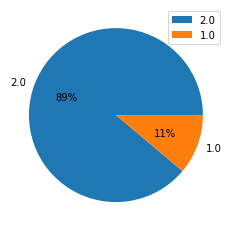

In [147]:
data, label = get_pie_chart(df, 'Y')
plt.pie(data, labels=label, autopct='%1.00f%%')
plt.legend()
print(np.array(data))
pass

[471  55]


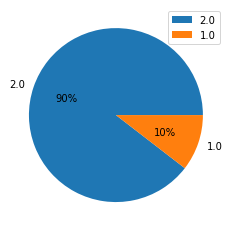

In [148]:
data, label = get_pie_chart(imp, 'Y')
plt.pie(data, labels=label, autopct='%1.0f%%')
plt.legend()
print(np.array(data))
pass

In [124]:
imp.to_csv('prepared_for_rsf_KNN_imputation.csv', index=False)

In [144]:
imputer = IterativeImputer(max_iter=20, random_state=0)
numpy_df = df.to_numpy()
imputer.fit(numpy_df)
imp = pd.DataFrame(np.round(imputer.transform(numpy_df)), columns = df.columns)
imp['BC'] /= 10
imp.head(10)

,Y,AF,AQ,AY,BC,BE,BG,BH,BI,BL,...,DE,DT,DW,DX,DY,EZ,Age,metastasis,dead,secondprim
0,1.0,1.0,4.0,3.0,3.3,3.0,2.0,1.0,1.0,2.0,...,1.0,2.0,2.0,2.0,2.0,103.0,44.0,2.0,1.0,2.0
1,1.0,2.0,4.0,2.0,3.6,3.0,2.0,1.0,1.0,2.0,...,1.0,1.0,2.0,1.0,1.0,153.0,51.0,2.0,1.0,2.0
2,2.0,2.0,4.0,3.0,4.5,3.0,2.0,1.0,1.0,2.0,...,1.0,2.0,2.0,2.0,2.0,160.0,53.0,2.0,1.0,2.0
3,2.0,2.0,2.0,3.0,3.4,3.0,2.0,1.0,1.0,2.0,...,1.0,2.0,2.0,2.0,2.0,115.0,59.0,2.0,1.0,2.0
4,1.0,2.0,4.0,3.0,3.4,3.0,2.0,1.0,1.0,2.0,...,1.0,2.0,2.0,2.0,2.0,52.0,40.0,2.0,1.0,2.0
5,2.0,2.0,6.0,3.0,3.3,3.0,2.0,1.0,1.0,2.0,...,1.0,2.0,2.0,2.0,2.0,298.0,33.0,2.0,1.0,2.0
6,2.0,2.0,2.0,2.0,3.4,3.0,1.0,1.0,2.0,1.0,...,1.0,2.0,2.0,2.0,2.0,168.0,83.0,2.0,1.0,2.0
7,2.0,2.0,2.0,2.0,5.0,5.0,1.0,1.0,1.0,1.0,...,1.0,2.0,2.0,2.0,2.0,162.0,80.0,2.0,1.0,2.0
8,2.0,2.0,2.0,3.0,3.0,3.0,1.0,1.0,2.0,1.0,...,1.0,1.0,1.0,1.0,2.0,76.0,71.0,2.0,1.0,2.0
9,1.0,2.0,5.0,3.0,3.4,3.0,2.0,1.0,1.0,2.0,...,1.0,2.0,2.0,2.0,2.0,225.0,57.0,2.0,1.0,2.0


In [149]:
imp.to_csv('prepared_for_rsf_Iterative_imputation.csv', index=False)